## Sirada Thoungvitayasutee 301292632
## Assignment 5

In [1]:
#import
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_olivetti_faces
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist
from scipy.stats import mode
from sklearn.mixture import GaussianMixture
from scipy.ndimage import rotate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

### 1. Use the training set, validation set, and test set from Assignment 3 (Hierarchical Clustering) for this Assignment

In [2]:
data = fetch_olivetti_faces(shuffle=True, random_state=42)
X = data.data
y = data.target

In [3]:
print(X.shape)
print(y.shape)

(400, 4096)
(400,)


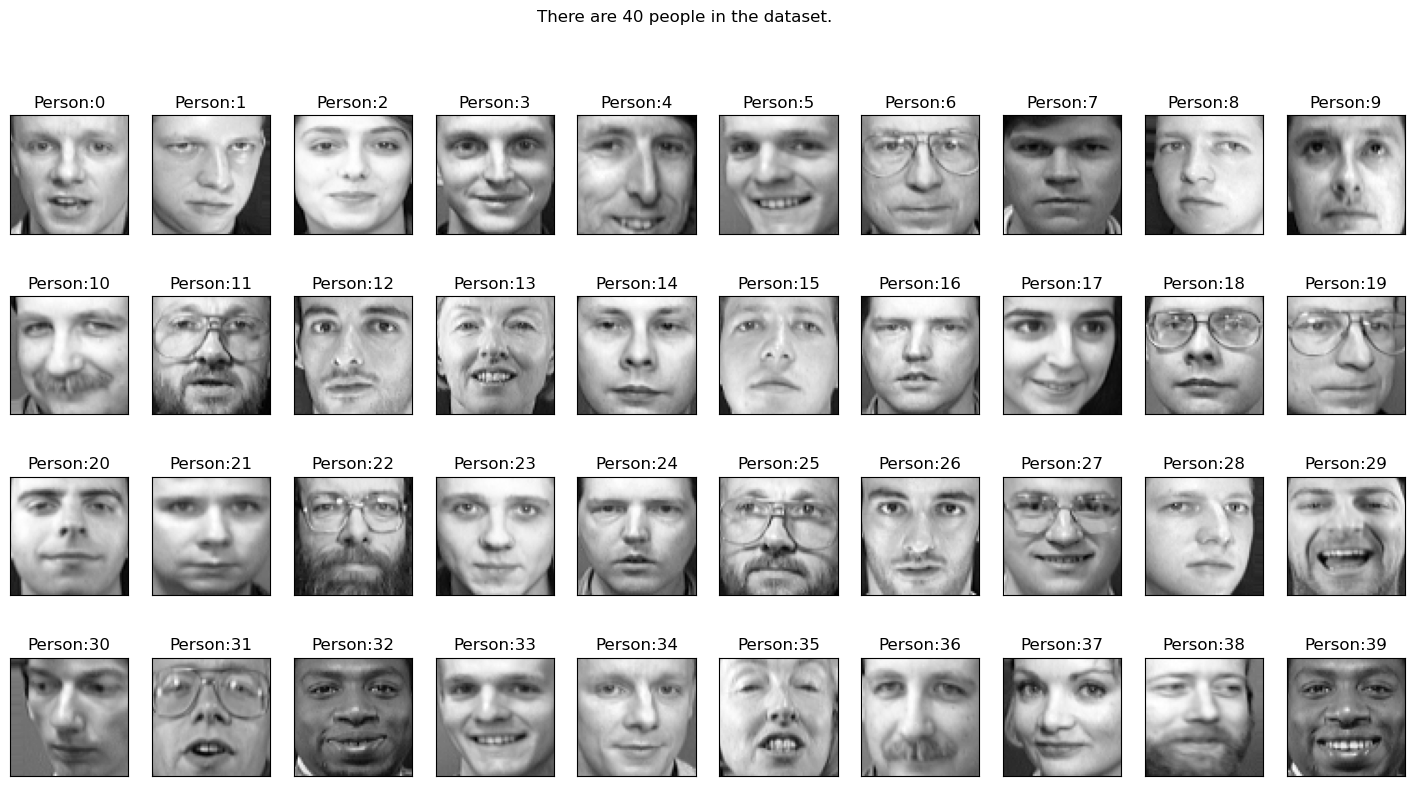

In [4]:
#print sample of the faces
def show_sample_faces(images, unique_ids):
    fig, axarr = plt.subplots(nrows=4, ncols=10, figsize=(18,9))
    axarr = axarr.flatten()
    
    for unique_id in unique_ids:
        image_index = unique_id*10
        #reshape from flattened to 64x64
        image_reshaped = images[image_index].reshape(64,64) 
        axarr[unique_id].imshow(image_reshaped, cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title('Person:{}'.format(unique_id))
    plt.suptitle('There are 40 people in the dataset.')

show_sample_faces(X, np.unique(y))

In [5]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, temp_index = next(split.split(X,y))
X_train, X_temp = X[train_index], X[temp_index]
y_train, y_temp = y[train_index], y[temp_index]

#split testing and val
split_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_index, test_index = next(split_val_test.split(X_temp, y_temp))
X_val, X_test = X_temp[val_index], X_temp[test_index]
y_val, y_test = y_temp[val_index], y_temp[test_index]
#output
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Val set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (320, 4096), (320,)
Val set: (40, 4096), (40,)
Test set: (40, 4096), (40,)


<Axes: title={'center': 'Training Set: Number of Samples Per Class'}, xlabel='subject ids'>

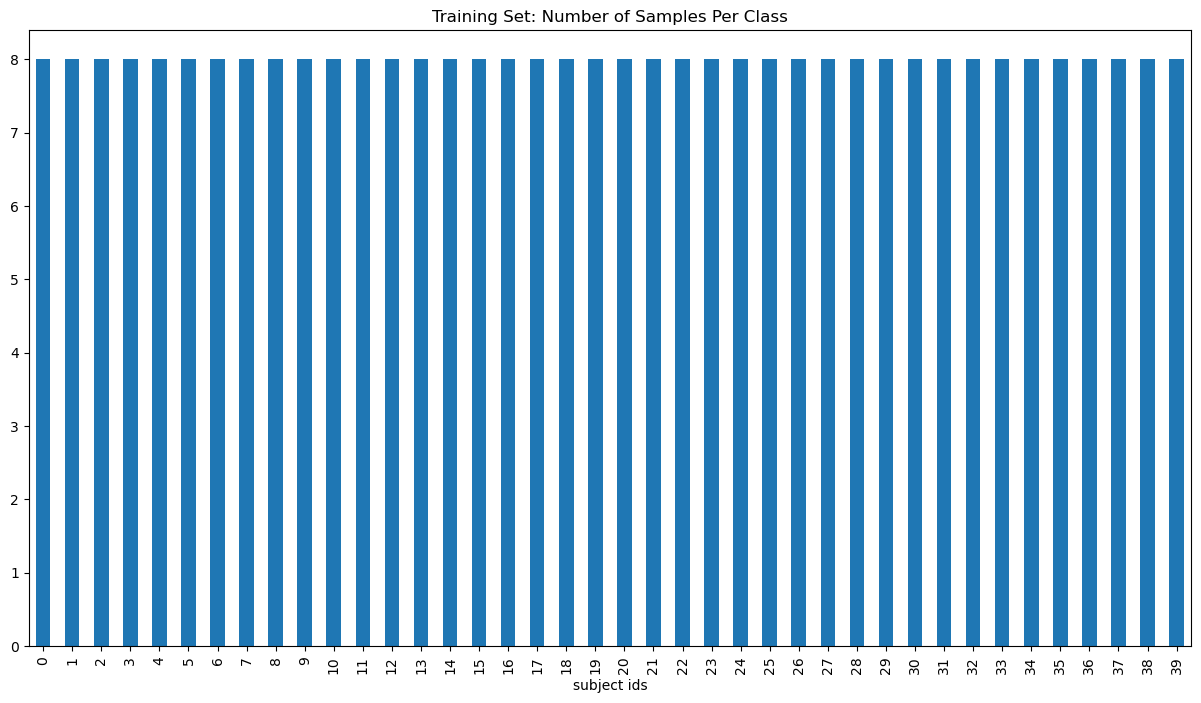

In [6]:
#print the graph to ensure that each person has same number of images
y_frame = pd.DataFrame()
y_frame['subject ids'] = y_train
y_frame.groupby(['subject ids']).size().plot.bar(figsize=(15,8), title='Training Set: Number of Samples Per Class')

<Axes: title={'center': 'Validation Set: Number of Samples Per Class'}, xlabel='subject ids'>

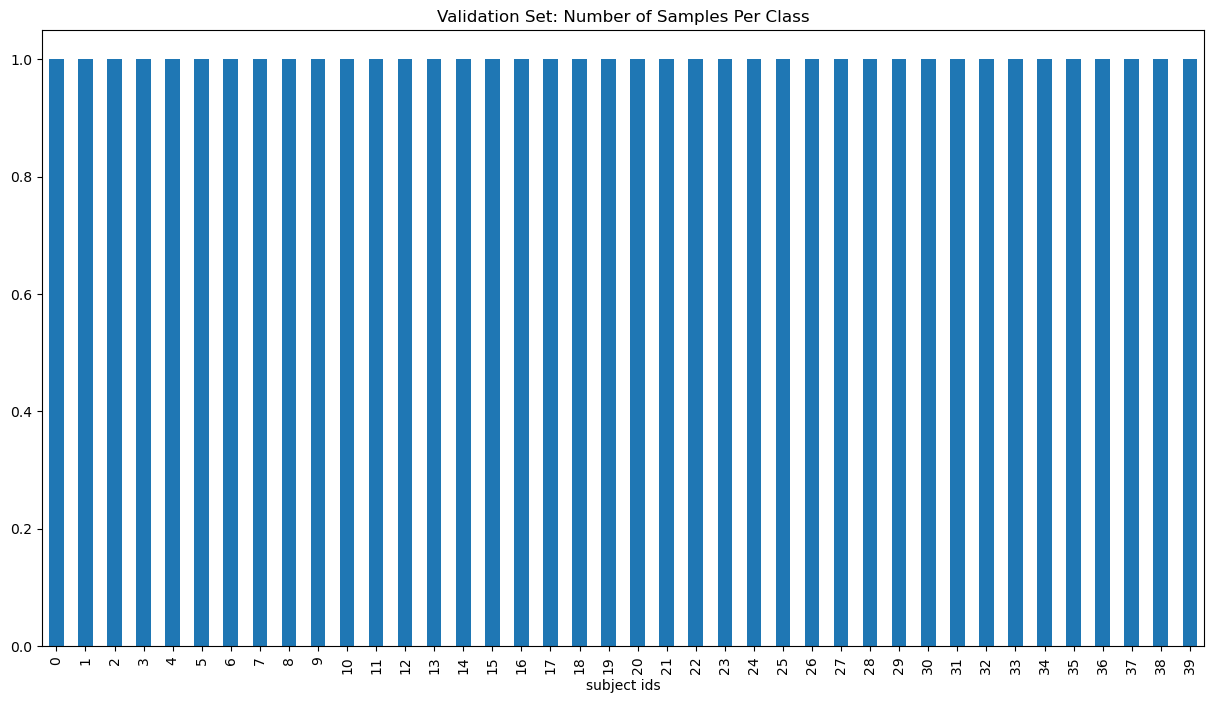

In [7]:
#print the graph to ensure that each person has same number of images
y_frame = pd.DataFrame()
y_frame['subject ids'] = y_val
y_frame.groupby(['subject ids']).size().plot.bar(figsize=(15,8), title='Validation Set: Number of Samples Per Class')

<Axes: title={'center': 'Testing Set: Number of Samples Per Class'}, xlabel='subject ids'>

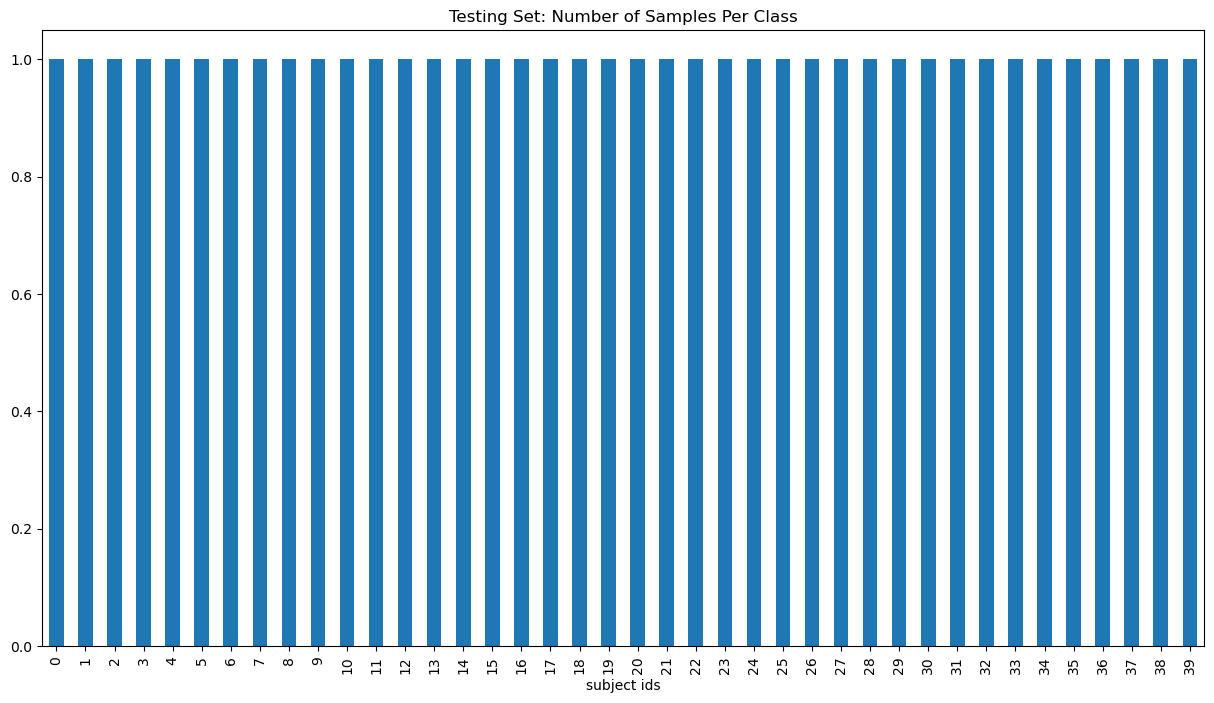

In [8]:
#print the graph to ensure that each person has same number of images
y_frame = pd.DataFrame()
y_frame['subject ids'] = y_test
y_frame.groupby(['subject ids']).size().plot.bar(figsize=(15,8), title='Testing Set: Number of Samples Per Class')

### 2. Use PCA preserving 99% of the variance to reduce the dataset’s dimensionality as in Assignment 4 (Gaussian Mixture Models) and use it to train the autoencoder

In [9]:
#preserving 99%
# keep enough principal components so that 99% fo the data's variance is retained
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train)

print(X_train_pca.shape)
print(X_train.shape)

(320, 221)
(320, 4096)


In [10]:
print(f'Max X Train: {np.max(X_train)}')
print(f'Min X Train: {np.min(X_train)}')
print(f'Max X Train PCA: {np.max(X_train_pca)}')
print(f'Min X Train PCA: {np.min(X_train_pca)}')

Max X Train: 1.0
Min X Train: 0.0
Max X Train PCA: 11.01727294921875
Min X Train PCA: -11.24036693572998


### 3. Define an autoencoder

In [11]:
#get dimension
input_dim = X_train_pca.shape[1]
print(input_dim)

221


### 3a) Use k-fold cross validation to fine tune the model’s learning rate and hyperparameter of the regularizer.  Due to the long training requirements, for the number of hidden units, try two or three different values for each hidden layer.

In [12]:
def build_autoencoder(input_dim, hidden_units1, hidden_units2, learning_rate, regularizer_value):
    #input layer
    input_layer = Input(shape=(input_dim,))
    #hidden layer 1
    encoded = Dense(hidden_units1, activation = 'relu', kernel_regularizer=l2(regularizer_value))(input_layer)
    #central layer
    latent_space = Dense(hidden_units2, activation='relu', kernel_regularizer=l2(regularizer_value))(encoded)

    #decoder layer
    #hidden layer
    decoded = Dense(hidden_units1, activation = 'relu', kernel_regularizer = l2(regularizer_value))(latent_space)
    output_layer = Dense(input_dim)(decoded)

    #compile the model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    optimizer = Adam(learning_rate = learning_rate)
    autoencoder.compile(optimizer=optimizer, loss = 'mean_squared_error')

    return autoencoder

In [13]:
#hyperparameters
learning_rates = [0.001, 0.0005, 0.0001]
regularizer_values = [0.01, 0.001, 0.0001]
hidden_units_combined = [(512,256),(256,128),(128,64)]

In [14]:
#k folds
kf = KFold(n_splits=5)

In [15]:
#find best loss and params
results = []

In [16]:
#find best params
for lr in learning_rates:
    for reg in regularizer_values:
        for hidden_units in hidden_units_combined:
            fold_train_loss =[]
            fold_val_loss = []
            for train_index, val_index in kf.split(X_train_pca):
                X_train_fold, X_val_fold = X_train_pca[train_index], X_train_pca[val_index]
                #build model
                autoencoder = build_autoencoder(
                    input_dim=X_train_pca.shape[1],
                    hidden_units1 = hidden_units[0],
                    hidden_units2 = hidden_units[1],
                    learning_rate=lr,
                    regularizer_value=reg
                )
                #early stopping
                early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                #history
                history = autoencoder.fit(
                    X_train_fold, X_train_fold,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val_fold, X_val_fold),
                    callbacks=[early_stopping],
                    verbose=0
                )
                fold_train_loss.append(min(history.history['loss']))
                fold_val_loss.append(min(history.history['val_loss']))
            avg_train_loss = np.mean(fold_train_loss)    
            avg_val_loss = np.mean(fold_val_loss)
            results.append({
                'learning_rate': lr,
                'regularizer': reg,
                'hidden_units': hidden_units,
                'average_train_loss' : avg_train_loss,
                'average_val_loss': avg_val_loss
            })
            print(f'learning rate: {lr}, regularizer: {reg}, hidden units: {hidden_units}, avg train loss: {avg_train_loss}, avg val loss: {avg_val_loss}')

learning rate: 0.001, regularizer: 0.01, hidden units: (512, 256), avg train loss: 0.22771146893501282, avg val loss: 0.23502436578273772
learning rate: 0.001, regularizer: 0.01, hidden units: (256, 128), avg train loss: 0.2388179749250412, avg val loss: 0.2476181596517563
learning rate: 0.001, regularizer: 0.01, hidden units: (128, 64), avg train loss: 0.2523751676082611, avg val loss: 0.260047847032547
learning rate: 0.001, regularizer: 0.001, hidden units: (512, 256), avg train loss: 0.11667387187480927, avg val loss: 0.14602988660335542
learning rate: 0.001, regularizer: 0.001, hidden units: (256, 128), avg train loss: 0.12794252932071687, avg val loss: 0.15430971682071687
learning rate: 0.001, regularizer: 0.001, hidden units: (128, 64), avg train loss: 0.14243026077747345, avg val loss: 0.16635509133338927
learning rate: 0.001, regularizer: 0.0001, hidden units: (512, 256), avg train loss: 0.04933170452713966, avg val loss: 0.10329127460718154
learning rate: 0.001, regularizer: 0

In [17]:
def find_best_params(results, overfitting_threshold=1.5):
    sorted_results = sorted(results, key=lambda x: x['average_val_loss'])
    best_result = None
    for result in sorted_results:
        print(f"learning rate: {result['learning_rate']}")
        print(f"regularizer: {result['regularizer']}")
        print(f"hidden units: {result['hidden_units']}")
        print(f"avg train loss: {result['average_train_loss']}")
        print(f"avg val loss: {result['average_val_loss']}")
        #check for overfitting, if val loss is 1.5 times more than train loss
        if result['average_val_loss'] > overfitting_threshold*result['average_train_loss']:
            print('Overfitting')
        else:
            best_result = result
            print('Not Overfitting')
            break
    #if all produces overfitting, select the best loss
    if best_result is None:
        best_result = sorted_results[0]
    return best_result

best_result = find_best_params(results)

learning rate: 0.001
regularizer: 0.0001
hidden units: (512, 256)
avg train loss: 0.04933170452713966
avg val loss: 0.10329127460718154
Overfitting
learning rate: 0.001
regularizer: 0.0001
hidden units: (256, 128)
avg train loss: 0.05642848387360573
avg val loss: 0.10652586966753005
Overfitting
learning rate: 0.001
regularizer: 0.0001
hidden units: (128, 64)
avg train loss: 0.07369076460599899
avg val loss: 0.11530524343252183
Overfitting
learning rate: 0.0005
regularizer: 0.0001
hidden units: (512, 256)
avg train loss: 0.06802124977111816
avg val loss: 0.12066778838634491
Overfitting
learning rate: 0.0005
regularizer: 0.0001
hidden units: (256, 128)
avg train loss: 0.074723219871521
avg val loss: 0.12339917421340943
Overfitting
learning rate: 0.0005
regularizer: 0.0001
hidden units: (128, 64)
avg train loss: 0.09694101214408875
avg val loss: 0.13780369460582734
Not Overfitting


In [18]:
#build with best params

autoencoder = build_autoencoder(
    input_dim = X_train_pca.shape[1],
    hidden_units1=best_result['hidden_units'][0],
    hidden_units2=best_result['hidden_units'][1],
    learning_rate=best_result['learning_rate'],
    regularizer_value=best_result['regularizer']
)

In [19]:
autoencoder.summary()

Model: "model_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_136 (InputLayer)      [(None, 221)]             0         
                                                                 
 dense_540 (Dense)           (None, 128)               28416     
                                                                 
 dense_541 (Dense)           (None, 64)                8256      
                                                                 
 dense_542 (Dense)           (None, 128)               8320      
                                                                 
 dense_543 (Dense)           (None, 221)               28509     
                                                                 
Total params: 73501 (287.11 KB)
Trainable params: 73501 (287.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 4. Run the best model with the test set and display the original image and the reconstructed image.

In [20]:
#apply PCA to the test set
X_test_pca = pca.transform(X_test)
test_loss = autoencoder.evaluate(X_test_pca, X_test_pca)
X_test_reconstructed = autoencoder.predict(X_test_pca)

2/2 [==============================] - 0s 4ms/step


In [21]:
#bring data back to before PCA
# X_test_original_images = pca.inverse_transform(X_test_pca)
X_test_reconstructed_images = pca.inverse_transform(X_test_reconstructed)

In [22]:
def show_image(original_images, reconstructed_images, n_images=10):
    plt.figure(figsize=(20,4))
    for i in range(n_images):
        ax = plt.subplot(2, n_images, i+1)
        plt.imshow(original_images[i].reshape(64,64), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'Original {i+1}')
        #reconstructed image
        ax = plt.subplot(2, n_images, i+1+n_images)
        plt.imshow(reconstructed_images[i].reshape(64,64), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'Reconstructed {i+1}')

    plt.suptitle('Original vs Reconstructed Images')
    plt.show()

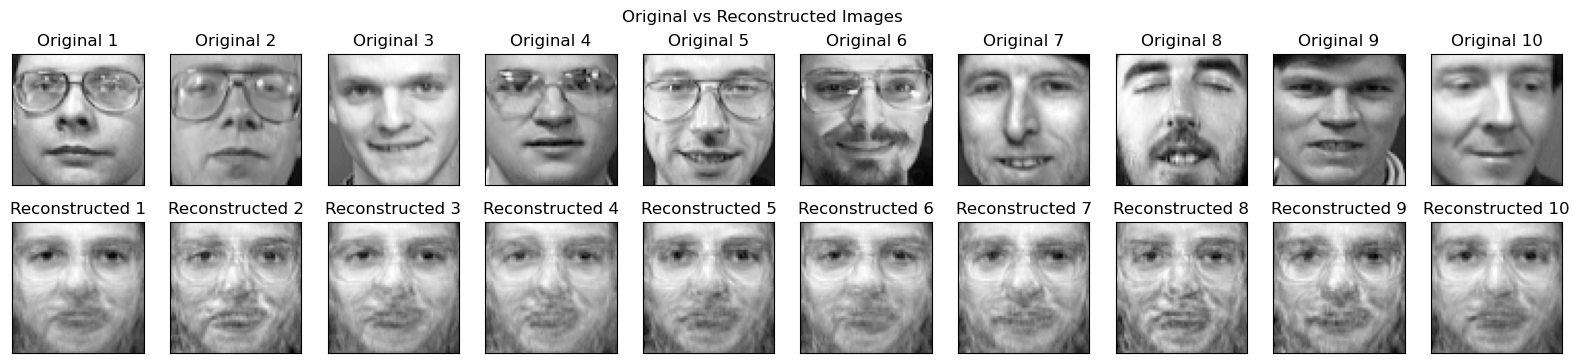

In [23]:
#show first 10 images
show_image(X_test, X_test_reconstructed_images, n_images=10)

In [24]:
np.min(X_test_reconstructed)

-0.8085153